# Recidivism Data and Preliminary Analysis

In this notebook, we have imported our datasets and performed some preliminary analysis. 

For reference, the datasets have been obtained from:
1. https://catalog.data.gov/dataset/recidivism-beginning-2008
2. https://data.ojp.usdoj.gov/Courts/NIJ-s-Recidivism-Challenge-Full-Dataset/ynf5-u8nk

In [49]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

In [50]:
# Load data into data frames 
NIJ_df = pd.read_csv('NIJ_s_Recidivism_Challenge_Full_Dataset_20231029.csv')

In [51]:
# Information about the NIJ data
NIJ_df.head(5)

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0.000000,0.0,0.488562,0.447610,False,False,False,False,False,1
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.000000,0.0,0.425234,2.000000,False,True,False,False,True,1
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,0.166667,0.0,0.000000,0.000000,False,True,False,True,False,1
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.000000,0.0,1.000000,0.718996,False,False,False,False,False,1
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0.058824,0.0,0.203562,0.929389,False,True,True,False,False,1


In [52]:
# Inspect the types of the columns and number of non-null rows
NIJ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25835 entries, 0 to 25834
Data columns (total 54 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 25835 non-null  int64  
 1   Gender                                             25835 non-null  object 
 2   Race                                               25835 non-null  object 
 3   Age_at_Release                                     25835 non-null  object 
 4   Residence_PUMA                                     25835 non-null  int64  
 5   Gang_Affiliated                                    22668 non-null  object 
 6   Supervision_Risk_Score_First                       25360 non-null  float64
 7   Supervision_Level_First                            24115 non-null  object 
 8   Education_Level                                    25835 non-null  object 
 9   Depend

Data types:
- Gang_Affiliated should be represented in bool.
- The following should be numbers (that aren't already booleans)
    - Prior_Arrest_Episodes_[...]
    - Prior_Conviction_Episodes_[...]
    - Prior_Revocations_[Parole/Probation]
    - Program_[Attendances/UnexcusedAbsences]

The problem we will be facing in this dataset is that there are certain variables that would be better represented as ints such as Dependents, Prison_Years, the various types of Prior_Arrest and Prior_Conviction, and others. Some of them are represented by bools which are also fine, but in general, those represented by object would be better represented as int so we can apply statistical analyses on it. We will determine how to address the values that are "More than..." and "Less than..." x values which cause these variables to be represented as objects rather than ints.

This is a major challenge we are facing working with this dataset that we need to addrress.

In [53]:
# Turn the objects for these columns into integers
NIJ_df["Prior_Arrest_Episodes_Felony"].unique()
cols_to_make_int = [
    "Dependents",
    "Prior_Arrest_Episodes_Felony",
    "Prior_Arrest_Episodes_Misd",
    "Prior_Arrest_Episodes_Violent",
    "Prior_Arrest_Episodes_Property",
    "Prior_Arrest_Episodes_Drug",
    "Prior_Arrest_Episodes_PPViolationCharges",
    "Prior_Conviction_Episodes_Felony",
    "Prior_Conviction_Episodes_Misd",
    "Prior_Conviction_Episodes_Prop",
    "Prior_Conviction_Episodes_Drug",
    "Program_Attendances",
    "Program_UnexcusedAbsences",
    "Residence_Changes"
]

for col in cols_to_make_int:
    NIJ_df[col] = NIJ_df[col].apply(lambda x: int(x) if " " not in x else int(x[:2]))

We will have to decide which of these columns are good for our study and exclude the ones that are not (these would be some of the ones with the missing data). We can also delete the rows with invalid data depending on if that category will be needed for a more thorough analysis. 


In [54]:
# Check the frequency of null values in each column
null_counts = NIJ_df.isnull().sum()
print('Null Values:')
print(null_counts)
print()
print()

# Create a Boolean mask for empty values (denoted by '')
empty_values = NIJ_df.eq('')

# Calculate the total number of empty values in each column
empty_counts = empty_values.sum()
print('Empty Values:')
print(empty_counts)
print()
print()

# Calculate the percentage of empty values for each column to determine if empty values are a widespread issue or isolated case
percentage_empty = (empty_counts / len(NIJ_df)) * 100
print('Percentage of Empty Values:')
print(round(percentage_empty))
print()
print()

# Calculate the percentage of null values for each column to determine if null values are a widespread issue or isolated case
percentage_null = (null_counts / len(NIJ_df)) * 100
print('Percentage of Null Values:')
print(round(percentage_null))

Null Values:
ID                                                      0
Gender                                                  0
Race                                                    0
Age_at_Release                                          0
Residence_PUMA                                          0
Gang_Affiliated                                      3167
Supervision_Risk_Score_First                          475
Supervision_Level_First                              1720
Education_Level                                         0
Dependents                                              0
Prison_Offense                                       3277
Prison_Years                                            0
Prior_Arrest_Episodes_Felony                            0
Prior_Arrest_Episodes_Misd                              0
Prior_Arrest_Episodes_Violent                           0
Prior_Arrest_Episodes_Property                          0
Prior_Arrest_Episodes_Drug                              0
P

In general, we see that this dataset does not need a lot of data manipulation, imputation, and deletion because the percentages are very low for null, invalid, and empty values.

In [55]:
# Information about the NIJ data before checking for duplicates
print('There are {} rows and {} columns.'.format(NIJ_df.shape[0], NIJ_df.shape[1]))

NIJ_df.drop_duplicates(inplace=True) #remove any duplicate rows

# Information about the NIJ data after removing any duplicates
print('There are {} rows and {} columns.'.format(NIJ_df.shape[0], NIJ_df.shape[1]))

There are 25835 rows and 54 columns.
There are 25835 rows and 54 columns.


We see that there are no duplicate rows.

In [56]:
# Drop NA columns as to not interfre with model creation in the future
NIJ_df.dropna(inplace=True)

In [57]:
# Change data type of Gang_Affiliated to bool
NIJ_df['Gang_Affiliated'] = NIJ_df['Gang_Affiliated'].astype(bool)

In [58]:
# Statistical analysis
# Represent the counts, average, variation, smallest, 25th and 75th percentile, median, and largest values
NIJ_df.describe()

,ID,Residence_PUMA,Supervision_Risk_Score_First,Dependents,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,Prior_Arrest_Episodes_Violent,Prior_Arrest_Episodes_Property,Prior_Arrest_Episodes_Drug,Prior_Arrest_Episodes_PPViolationCharges,...,Program_UnexcusedAbsences,Residence_Changes,Avg_Days_per_DrugTest,DrugTests_THC_Positive,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Training_Sample
count,14170.000000,14170.000000,14170.000000,14170.000000,14170.000000,14170.000000,14170.000000,14170.000000,14170.000000,14170.000000,...,14170.000000,14170.000000,14170.000000,14170.000000,14170.00000,14170.000000,14170.000000,14170.000000,14170.000000,14170.000000
mean,13103.097036,12.314891,6.424841,1.425900,5.707975,3.306704,1.105434,2.191602,1.703458,2.285603,...,0.516584,0.880452,95.707029,0.072066,0.01469,0.012908,0.007449,0.525187,0.822754,0.694284
std,7508.784065,7.154915,2.327157,1.212094,3.159415,2.292671,1.085598,1.872249,1.686778,1.932358,...,1.007229,1.052489,120.615079,0.144861,0.06289,0.059696,0.041485,0.414983,0.826974,0.460726
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.500000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6699.250000,6.000000,5.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,29.500000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13076.500000,12.000000,6.000000,1.000000,5.000000,3.000000,1.000000,2.000000,1.000000,2.000000,...,0.000000,1.000000,56.097619,0.000000,0.00000,0.000000,0.000000,0.592486,0.683989,1.000000
75%,19488.750000,19.000000,8.000000,3.000000,9.000000,6.000000,2.000000,4.000000,3.000000,4.000000,...,0.000000,2.000000,111.287500,0.095238,0.00000,0.000000,0.000000,0.980211,1.012474,1.000000
max,26734.000000,25.000000,10.000000,3.000000,10.000000,6.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,3.000000,1088.500000,1.000000,1.00000,1.000000,1.000000,1.000000,8.000000,1.000000


The mean and the median are generally the same or very very close, meaning a symmetrical distribution.

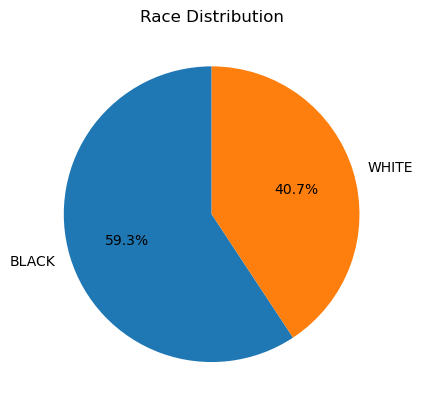

In [59]:
# Visualization showing the Race proportion
race_counts = NIJ_df['Race'].value_counts()
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Race Distribution")
plt.show()


Historically models that predict recidivism rely heavily on demographic data, resulting in models that are biased. We want to see these proprotions to address and avoid any bias in our work. As we can also see, this race distribution is very limited since it only shows Black and White races. For these reasons it is best to avoid using demographic data in our models.

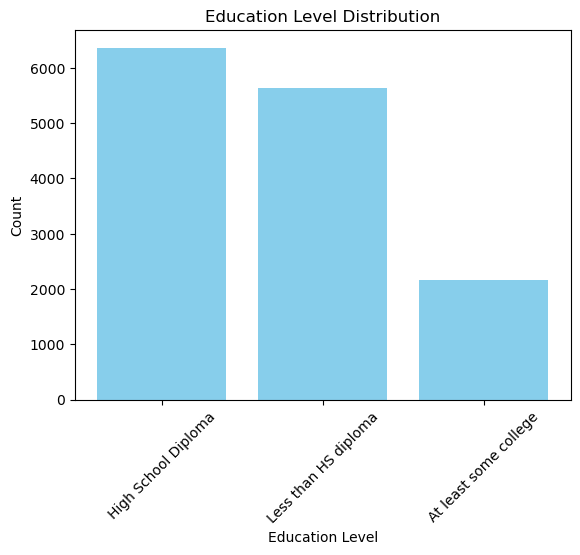

In [60]:
# Visualization showing the education level distribution
education_counts = NIJ_df['Education_Level'].value_counts()
plt.bar(education_counts.index, education_counts.values, color='skyblue')
plt.title("Education Level Distribution")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


As we can see, the most frequent education level is having some high school diploma among the individuals in this dataset. The least frequent education level is at least some college. Exploring this further can give us an idea on how education levels could impact recidivism or offending and help address bias.

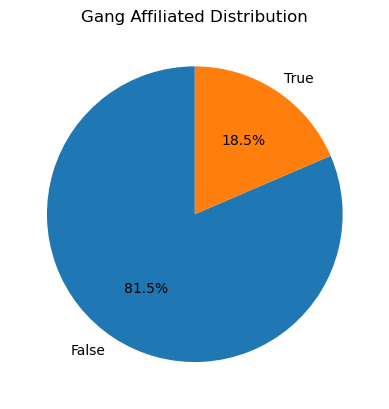

In [61]:
# Visualization showing the Gang Affiliation proportion
race_counts = NIJ_df['Gang_Affiliated'].value_counts()
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Gang Affiliated Distribution")
plt.show()


We can see that in this dataset where individuals were checked and revisted after 3 years, most did not have a gang affiliation after release.

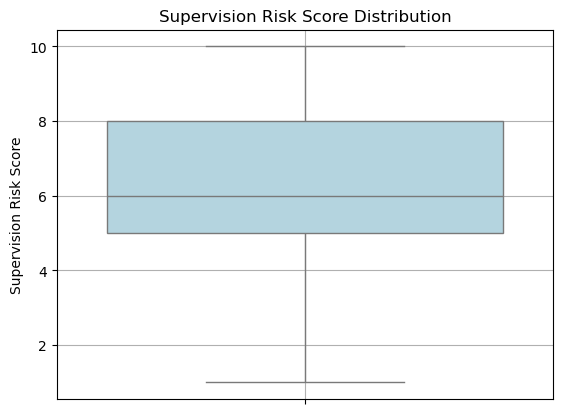

In [62]:
# Visualization showing the supervision risk score disribution through a box plot
sns.boxplot(data=NIJ_df, y="Supervision_Risk_Score_First", color='lightblue')
plt.title("Supervision Risk Score Distribution")
plt.ylabel("Supervision Risk Score")
plt.grid(True)
plt.show()



A higher supervision risk score is a riskier individual. This boxplot allows us to visualize the risk score percentiles. We see an even distribution.

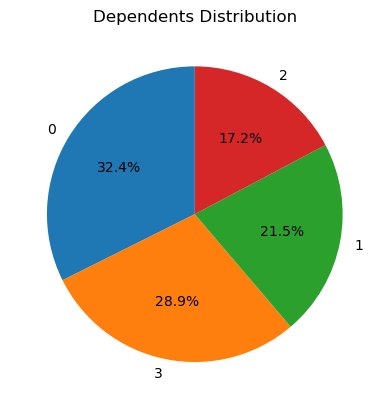

In [63]:
# Visualization showing the dependents distribution through a box plot
dependents_counts = NIJ_df['Dependents'].value_counts()
plt.pie(dependents_counts, labels=dependents_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Dependents Distribution")
plt.show()


From this chart, we can draw conclusions on if having dependents/being a parent has any effect on recidivsm. The fact that ~68% of individuals have dependents (ranging from 1-3+) show that maybe parenthood has an effect on recidivism.

# Model Creation Section
*We will be using the NIJ_df as our dataset*

We hope to use how much the individual was employed as a measure of success. We will discretize Percent_Days_Employed into a binary success indicator. We will consider success to be over 3%. This is because a large amount of inidivudals are at 0%. 

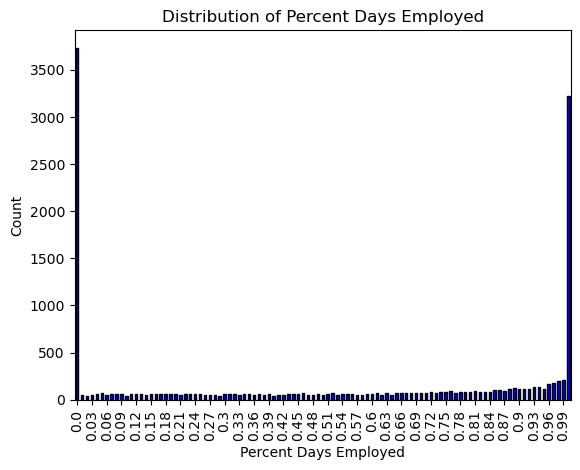

In [64]:
# Get the value counts of percent employment
value_counts = NIJ_df["Percent_Days_Employed"].apply(lambda x: round(x, 2)).value_counts().sort_index()

# Plot the distribution of employment percentages
value_counts.plot(kind='bar', color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Percent Days Employed')
plt.ylabel('Count')
plt.title('Distribution of Percent Days Employed')

# Set the ticks you want to display
# In this example, every 2nd tick will be displayed
plt.xticks(range(0, len(value_counts), 3))

plt.show()

In [65]:
# Create the variables we will be predicting as per the specifications above
NIJ_df["success"] = NIJ_df["Percent_Days_Employed"].apply(lambda x: False if x <= 0.03 else True)

print(NIJ_df["success"].value_counts())

success
True     10325
False     3845
Name: count, dtype: int64


In [66]:
# We will also want to use the education level as a feature.
# To simplify we will differentiate from if they went to college or not
NIJ_df['college'] = NIJ_df["Education_Level"].apply(lambda x: True if "college" in x else False)

In [67]:
# Get the features we will be using, separated from categorical and numerical

categorical_features = [
#    "Age_at_Release",
    "Supervision_Level_First",
#    "Prison_Offense",
    "Prison_Years",
    "Employment_Exempt",
    "college",
    "Condition_MH_SA",
    "Condition_Cog_Ed",
    "Condition_Other",
    "Prior_Conviction_Episodes_PPViolationCharges",
#    "Prior_Conviction_Episodes_DomesticViolenceCharges",
    "Prior_Conviction_Episodes_GunCharges",
#    "Prior_Revocations_Parole",
    "Prior_Revocations_Probation",
    "Prior_Conviction_Episodes_Viol",
    "Prior_Arrest_Episodes_DVCharges",
    "Prior_Arrest_Episodes_GunCharges",
]

numerical_features = [
    "Dependents",
    "Supervision_Risk_Score_First",
    "Prior_Arrest_Episodes_Felony",
    "Prior_Arrest_Episodes_Misd",
    "Prior_Arrest_Episodes_Violent",
    "Prior_Arrest_Episodes_Property",
    "Prior_Arrest_Episodes_Drug",
    "Prior_Arrest_Episodes_PPViolationCharges",
    "Prior_Conviction_Episodes_Felony",
    "Prior_Conviction_Episodes_Misd",
    "Prior_Conviction_Episodes_Prop",
    "Prior_Conviction_Episodes_Drug",
    "Program_Attendances",
    "Program_UnexcusedAbsences",
    "Residence_Changes",
#    "Percent_Days_Employed",
#     "Jobs_Per_Year",
]

features = categorical_features + numerical_features

In [68]:
target = "success"

## k-NN Algorithm

#### All Features

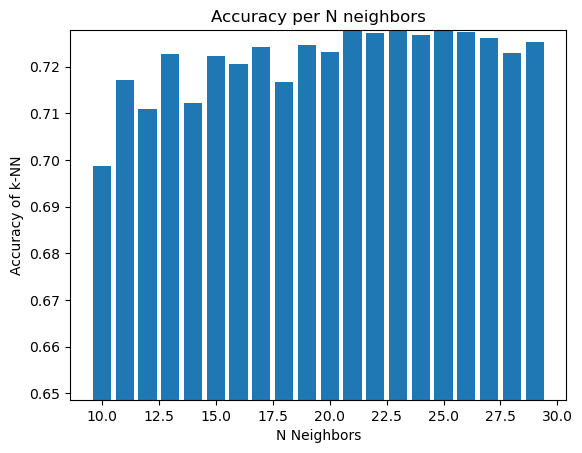

In [69]:
# input features (X) and target (y)
X = NIJ_df[features]
y = NIJ_df[target]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   random_state=42,
                                                   stratify=y
                                                   )

# Hyper Parameter Tuning (Different n_neighbors)
n_range = list(range(10, 30))
accuracy = []
for n in n_range:
    # Instantiate the Model
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    accuracy.append(acc)
    
# Create a visualization
fig, ax = plt.subplots()

ax.bar(n_range, accuracy)
ax.set_xlabel("N Neighbors")
ax.set_ylabel("Accuracy of k-NN")
ax.set_title("Accuracy per N neighbors")
plt.ylim(min(accuracy) - 0.05, max(accuracy))

plt.show()

## Random Forest Classifier

<span style="color: orange;"><em>scikit-learn 1.3.0 will cause errors, upgrade or downgrade</em></span>

#### All Features

In [70]:
# input features (X) and target (y)
X = NIJ_df[features]
y = NIJ_df[target]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42
                                                   )

# Model Creation
for n in range(100, 210, 20):
    rf = RandomForestClassifier(n_estimators=n,
                                random_state=42)
    rf.fit(X_train, y_train)
    # Make predictions for the test set
    y_pred_test = rf.predict(X_test)
    # View accuracy score
    print(f'{n}: Accuracy: {round(accuracy_score(y_test, y_pred_test), 4)}')

100: Accuracy: 0.7283
120: Accuracy: 0.7272
140: Accuracy: 0.7294
160: Accuracy: 0.7279
180: Accuracy: 0.7294
200: Accuracy: 0.7304


In [71]:
rf = RandomForestClassifier(n_estimators=200)
# Perform k-fold cross-validation (e.g., 5 folds)
cv_results = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

# Print the results
print("Cross-validation results:", cv_results)
print("Mean accuracy:", round(cv_results.mean(), 2))
print("Standard deviation:", round(cv_results.std(), 4))

Cross-validation results: [0.7292769  0.72827525 0.72562858 0.73489193 0.73224526]
Mean accuracy: 0.73
Standard deviation: 0.0032


It seems our model isn't a fluke as suggested by the cross validation results, similar means, and low standard deviation.

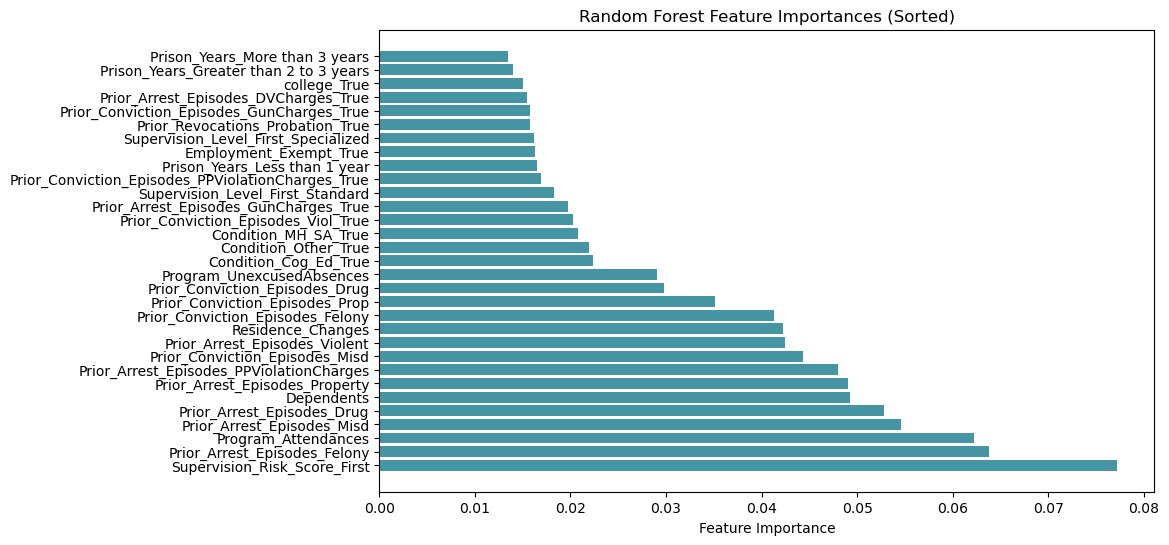

In [72]:
# Find the feature importances
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_

# Sort feature importances and corresponding column names
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_columns = X.columns[sorted_indices]

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center', color=['#4695A4'])
plt.yticks(range(len(sorted_importances)), sorted_columns)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances (Sorted)')
plt.show()

## SVM

#### All Features

In [73]:
# input features (X) and target (y)
X = NIJ_df[features]
y = NIJ_df[target]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42
                                                   )

# Instantiate the Model
svm = SVC()
svm.fit(X_train, y_train)

# Evaluate the prediction accuracy
print(f"The accuracy of SVM: {svm.score(X_test, y_test):.3f}")

The accuracy of SVM: 0.724


Below is our hyperparameter tuning for SVM. This takes a very, very long time and probably won't complete for at least an hour.

In [74]:
# Instantiate the Model with Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf']} 

svm_grid = GridSearchCV(SVC(), param_grid, refit = True) 
svm_grid.fit(X_train, y_train)

print(svm_grid.best_params_)
print(svm_grid.best_score_)

# As explained in our poster, the Random Forest algorithm is best for our task

**Sources:**

https://stackoverflow.com/questions/47417986/using-scipy-gaussian-kernel-density-estimation-to-calculate-cdf-inverse

https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

https://www.geeksforgeeks.org/oob-errors-for-random-forests-in-scikit-learn/#